In [108]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from env import get_db_url

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

# Acquire the data

In [61]:
def get_zillow_data():
    '''
    Function will try to return ad database from csv file if file is local and in same directory.
    IF file doesn't exist it will create and store in same directory
    Otherwise will pull from codeup database.
    Must have credentials for codeup database.
    '''
    query = '''
        SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, fips, transactiondate
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

JOIN predictions_2017 using(parcelid)

WHERE (propertylandusetypeid  = 261
or
propertylandusetypeid  =  279)
and  transactiondate like %s;
        '''
    params = ('2017%',)
    try:
        csv_info = pd.read_csv('zillow.csv', index_col=0 )
        return csv_info
    except FileNotFoundError:
        url = get_db_url('zillow')
        info = pd.read_sql(query, url, params=params)
        info.to_csv("zillow.csv", index=True)
        return info

In [62]:
df = get_zillow_data()


### Take a look

In [79]:
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,transactiondate
0,4.0,3.5,3100.0,1023282.0,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,6037.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,6037.0,2017-01-01
...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0,6037.0,2017-09-19
52437,2.0,2.0,1286.0,354621.0,6037.0,2017-09-20
52438,4.0,2.0,1612.0,67205.0,6111.0,2017-09-21
52439,3.0,1.0,1032.0,49546.0,6037.0,2017-09-21


### Let's look for Nulls

In [72]:
df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    82
taxvaluedollarcnt                1
fips                             0
transactiondate                  0
dtype: int64

In [73]:
df.calculatedfinishedsquarefeet.describe()

count    52359.000000
mean      1922.890754
std       1004.365838
min        128.000000
25%       1268.000000
50%       1659.000000
75%       2306.000000
max      21929.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [71]:
df[df.isna().any(axis=1)]

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,transactiondate
124,0.0,0.0,NaN,830145.0,6059.0,2017-01-03
3322,0.0,0.0,NaN,643406.0,6059.0,2017-01-24
4465,2.0,1.0,NaN,488078.0,6059.0,2017-01-31
4605,0.0,0.0,NaN,2909706.0,6059.0,2017-01-31
5065,0.0,0.0,NaN,5080924.0,6059.0,2017-02-02
...,...,...,...,...,...,...
46629,0.0,0.0,NaN,3489309.0,6037.0,2017-08-22
48412,0.0,0.0,NaN,3248800.0,6059.0,2017-08-30
48597,0.0,0.0,NaN,327761.0,6059.0,2017-08-30
49690,0.0,0.0,NaN,321981.0,6059.0,2017-09-02


### Nulls
   - 83 rows with nulls 
   - all but one in calculatedfinishedsquarefeet(area)
   - Gonna look at outliers before deciding what to do with the nulls

 ### Outliers 
 

In [80]:
cols = [col for col in df.columns if col not in ['fips', 'year_built', 'transactiondate']]

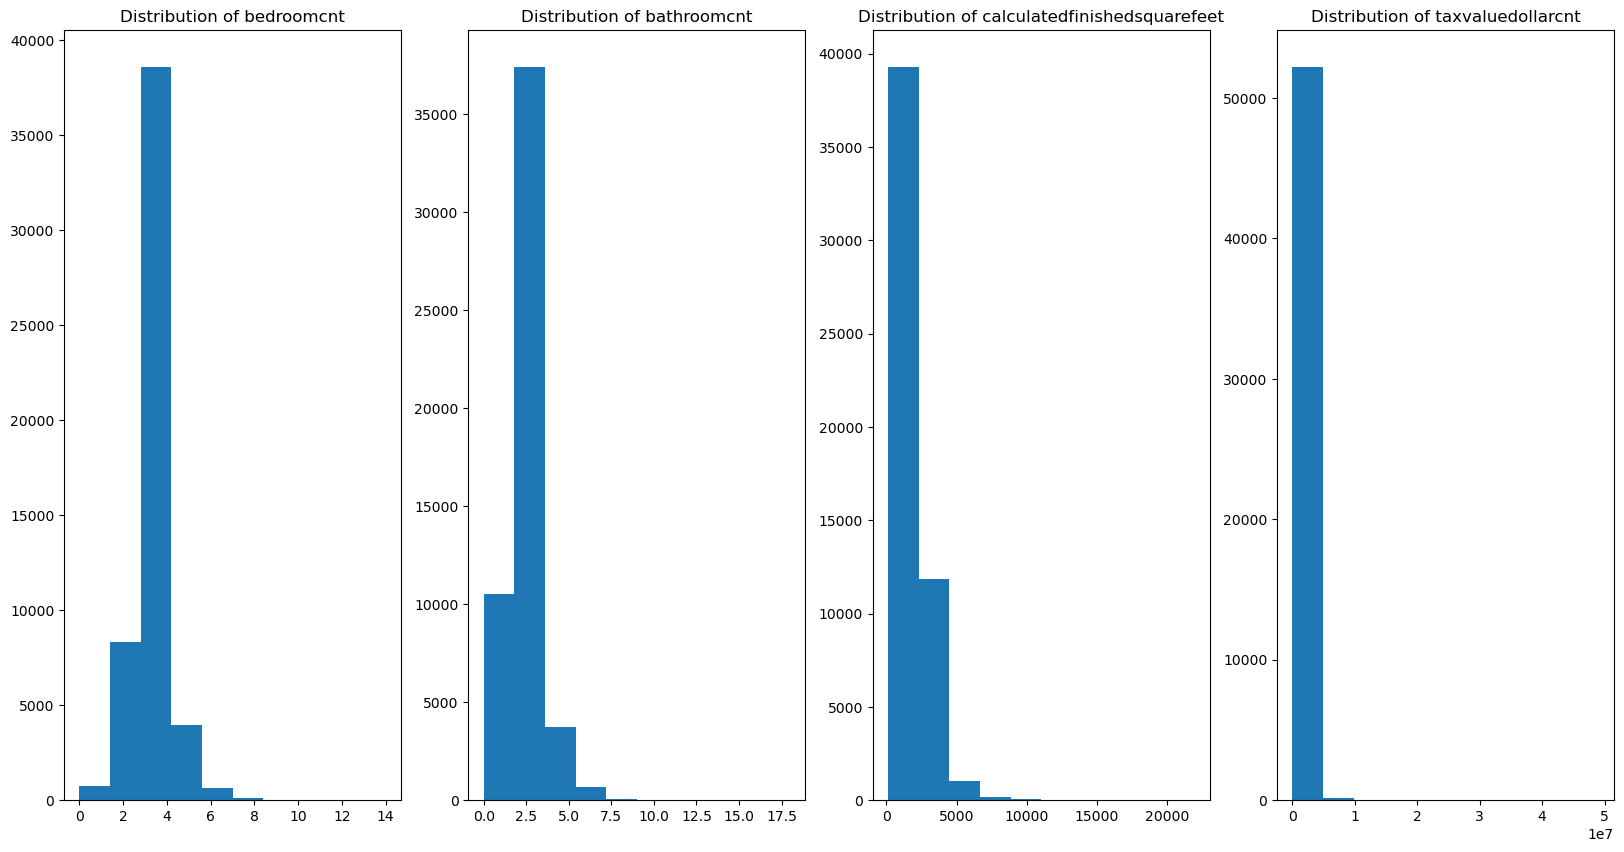

In [82]:
plt.figure(figsize=(20,10))
for i, col in enumerate(cols):
    # our plot numbers start at 1
    plot_number = i+1
    plt.subplot(1, len(cols), plot_number)
    plt.title(f'Distribution of {col}')
    df[col].hist(bins=10)
    plt.grid(False)
    plt.ticklabel_format(useOffset=False)
plt.show()

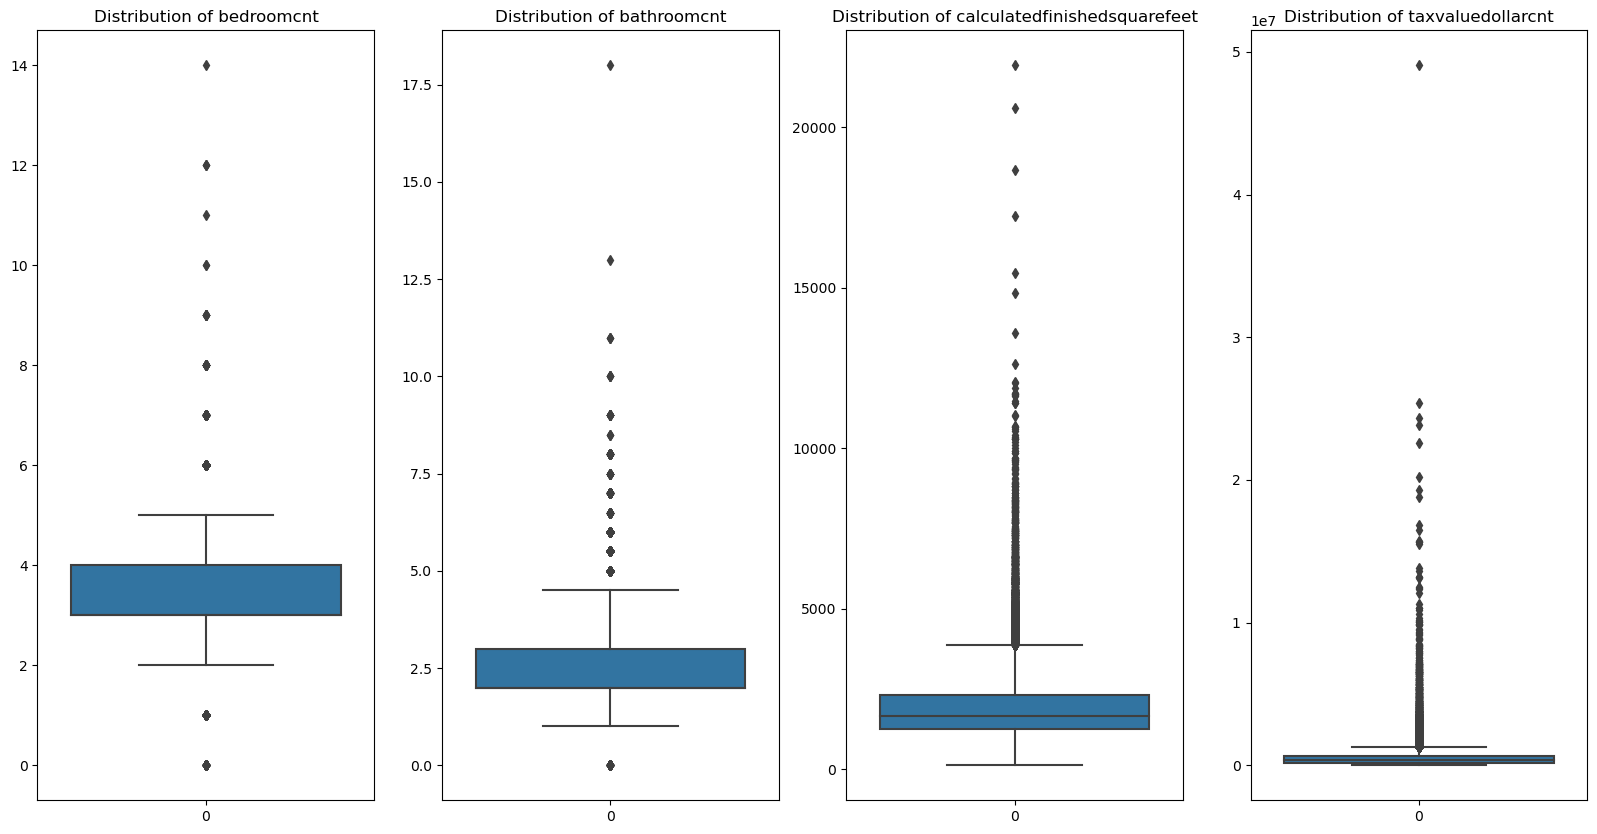

In [81]:
plt.figure(figsize=(20,10))
for i, col in enumerate(cols):
    # our plot numbers start at 1
    plot_number = i+1
    plt.subplot(1, len(cols), plot_number)
    plt.title(f'Distribution of {col}')
    plt.grid(False)
    sns.boxplot(data=df[col])
plt.show()

### Decision
   - bedroom and bathroom outliers are minimal 
   - area and taxvalue have more
### Im going to remove the majority of outliers for the mvp but look into it more on my next iterration 

### Removing the outliers outside the fenses 

In [83]:
def remove_outliers(df, col_list, k=1.5):
    '''
    remove outliers from a dataframe based on a list of columns
    using the tukey method.
    returns a single dataframe with outliers removed
    '''
    col_qs = {}
    for col in col_list:
        col_qs[col] = q1, q3 = df[col].quantile([0.25, 0.75])
    for col in col_list:
        iqr = col_qs[col][0.75] - col_qs[col][0.25]
        lower_fence = col_qs[col][0.25] - (k*iqr)
        upper_fence = col_qs[col][0.75] + (k*iqr)
        print(type(lower_fence))
        print(lower_fence)
        df = df[(df[col] > lower_fence) & (df[col] < upper_fence)]
    return df

In [87]:
df = remove_outliers(df, cols)

<class 'numpy.float64'>
1.5
<class 'numpy.float64'>
0.5
<class 'numpy.float64'>
-289.0
<class 'numpy.float64'>
-444583.125


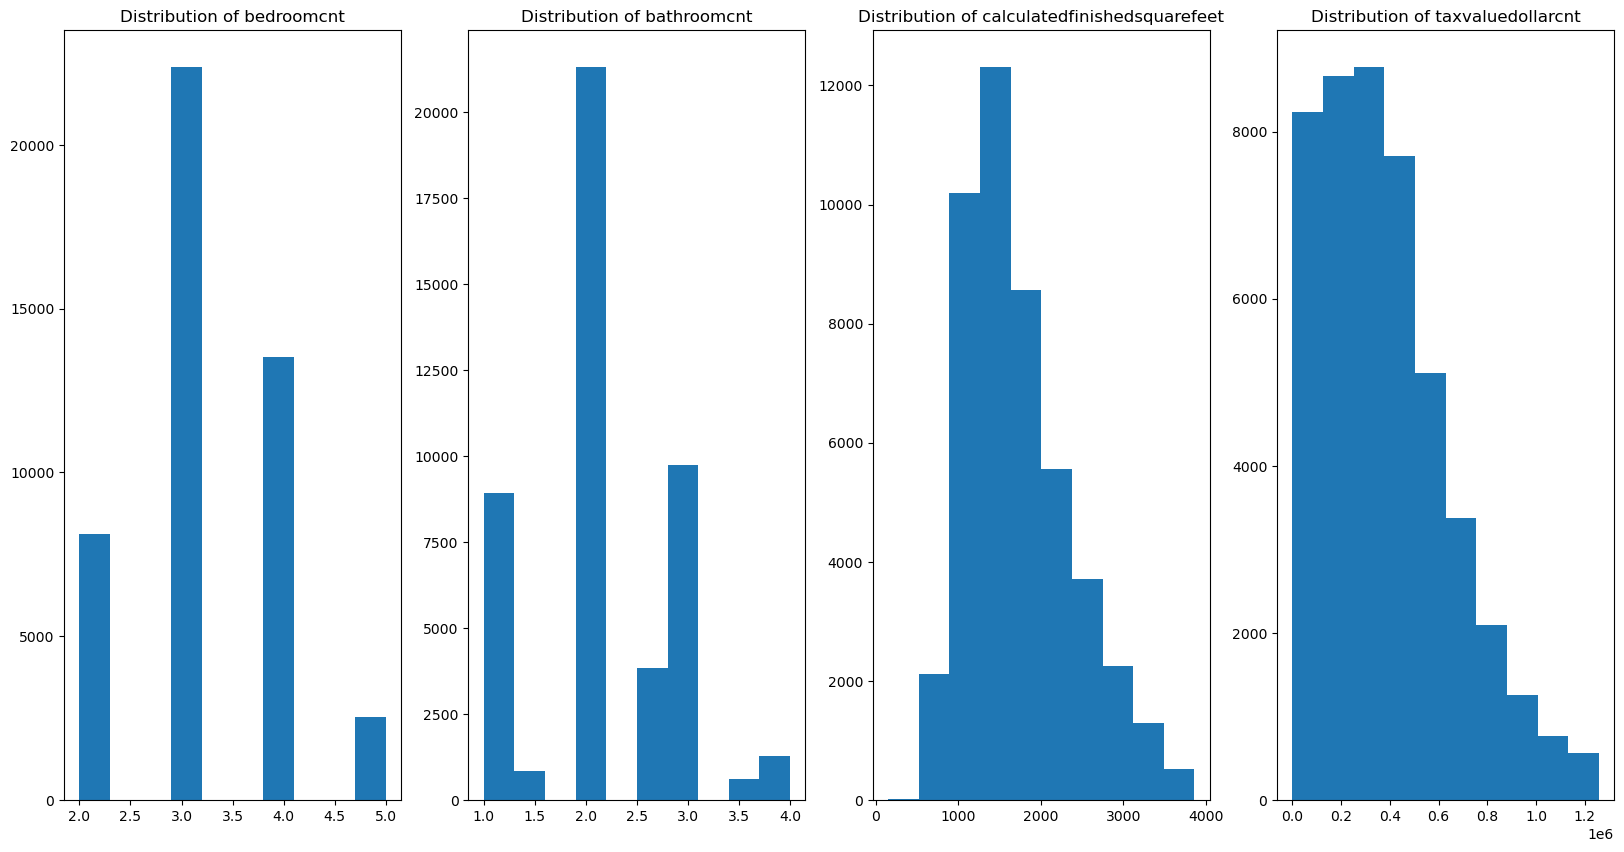

In [88]:
plt.figure(figsize=(20,10))
for i, col in enumerate(cols):
    # our plot numbers start at 1
    plot_number = i+1
    plt.subplot(1, len(cols), plot_number)
    plt.title(f'Distribution of {col}')
    df[col].hist(bins=10)
    plt.grid(False)
    plt.ticklabel_format(useOffset=False)
plt.show()

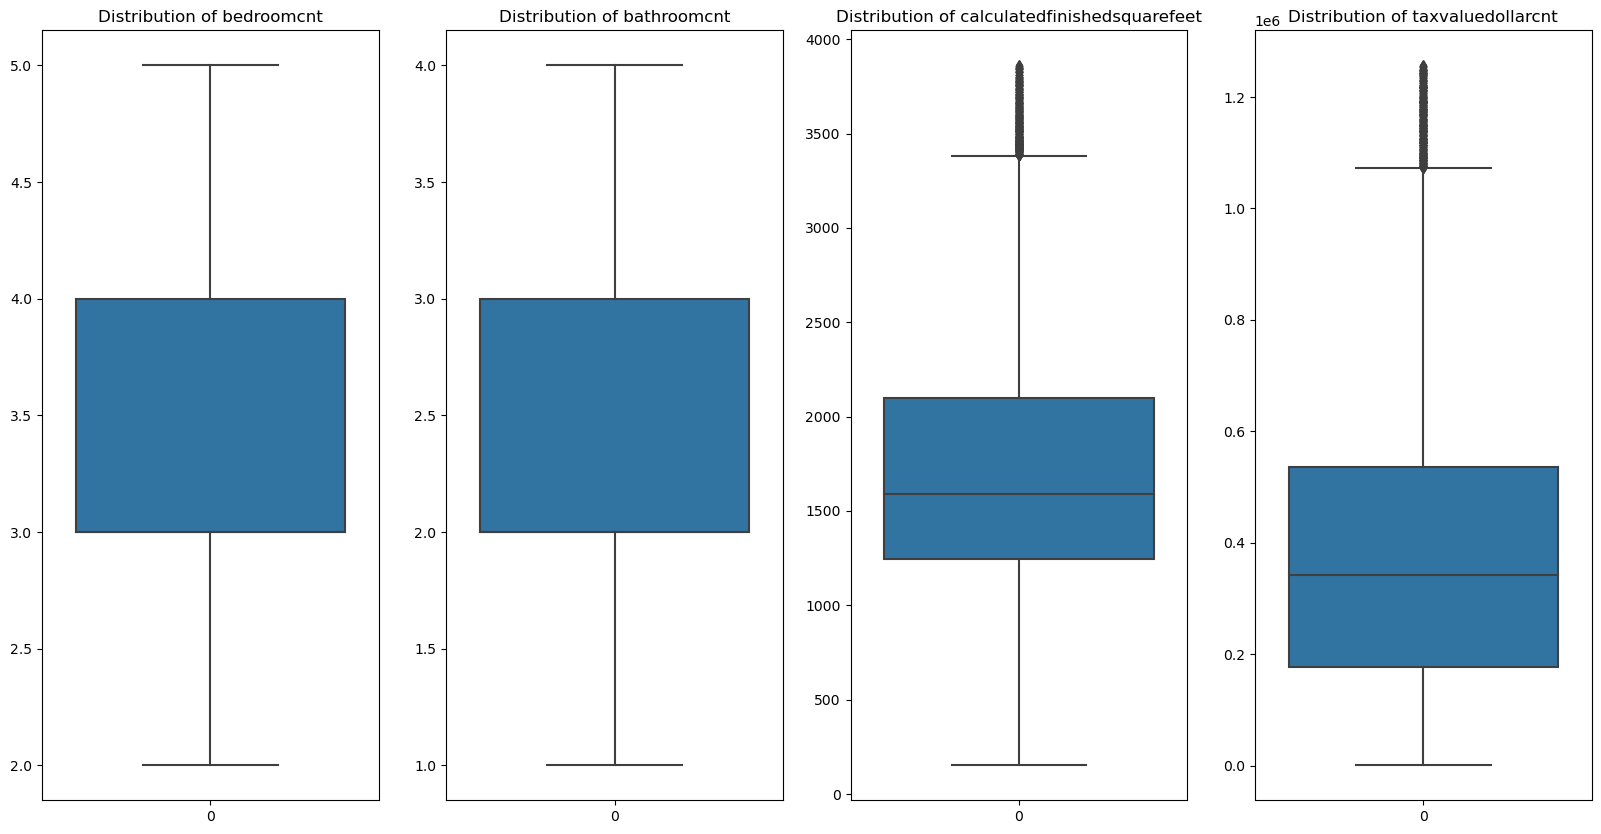

In [89]:
plt.figure(figsize=(20,10))
for i, col in enumerate(cols):
    # our plot numbers start at 1
    plot_number = i+1
    plt.subplot(1, len(cols), plot_number)
    plt.title(f'Distribution of {col}')
    plt.grid(False)
    sns.boxplot(data=df[col])
plt.show()

In [90]:
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,fips,transactiondate
0,4.0,3.5,3100.0,1023282.0,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,6037.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,6037.0,2017-01-01
...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0,6037.0,2017-09-19
52437,2.0,2.0,1286.0,354621.0,6037.0,2017-09-20
52438,4.0,2.0,1612.0,67205.0,6111.0,2017-09-21
52439,3.0,1.0,1032.0,49546.0,6037.0,2017-09-21


## Lets check the nulls again

In [91]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
fips                            0
transactiondate                 0
dtype: int64

#### yay!

In [100]:
def prep_zillow():
    '''
    Funtion will return a zillow dataframe with the outliers and nulls dropped and the data cleaned
    '''
    df = get_zillow_data()
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                                   'bathroomcnt':'bathrooms', 
                                   'calculatedfinishedsquarefeet':'area',
                                   'taxvaluedollarcnt':'tax_value',
                                    'transactiondate': 'sale_date'})
    
    cols = [col for col in df.columns if col not in ['fips', 'year_built', 'sale_date']]
    
    df = remove_outliers(df, cols)
    return df

## Gonna finish the wrangle now
## train, validate, test

In [104]:
df = prep_zillow()

<class 'numpy.float64'>
1.5
<class 'numpy.float64'>
0.5
<class 'numpy.float64'>
-289.0
<class 'numpy.float64'>
-444583.125


In [128]:
df.sale_date.dtype

dtype('O')

In [109]:
def wrangle_zillow():
    df = prep_zillow()
    train_val, test = train_test_split(df,
                                       train_size=0.8,
                                       random_state=706)
    train, validate = train_test_split(train_val,
                                       train_size=0.7,
                                       random_state=706)
    return train, validate, test

In [110]:
train, val, test = wrangle_zillow()

<class 'numpy.float64'>
1.5
<class 'numpy.float64'>
0.5
<class 'numpy.float64'>
-289.0
<class 'numpy.float64'>
-444583.125


In [113]:
train.shape, val.shape, test.shape

((26073, 6), (11175, 6), (9312, 6))

In [129]:
26073/46560 

0.5599871134020619

In [115]:
df

,bedrooms,bathrooms,area,tax_value,fips,sale_date
0,4.0,3.5,3100.0,1023282.0,6059.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,6111.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,6059.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,6037.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,6037.0,2017-01-01
...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,346534.0,6037.0,2017-09-19
52437,2.0,2.0,1286.0,354621.0,6037.0,2017-09-20
52438,4.0,2.0,1612.0,67205.0,6111.0,2017-09-21
52439,3.0,1.0,1032.0,49546.0,6037.0,2017-09-21


## scaling

In [121]:
def scale_data(train, val, test):
    x_cols = [col for col in train.columns if col not in ['tax_value', 'fips', 'sale_date', 'bedrooms', 'bathrooms']]
    split = [train, val, test]
    scale_list= []
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train[x_cols])
    for cut in split:
        cut_copy = cut.copy()
        cut_copy[x_cols] = scaler.transform(cut_copy[x_cols])
        scale_list.append(cut_copy)

    
    return scale_list[0], scale_list[1], scale_list[2] 

In [122]:
scale_train, scale_val, scale_test = scale_data(train, val, test)

In [123]:
scale_train

,bedrooms,bathrooms,area,tax_value,fips,sale_date
31478,4.0,2.0,0.311155,147333.0,6059.0,2017-06-15
30505,3.0,2.0,0.236127,475000.0,6037.0,2017-06-09
44417,2.0,1.0,0.111552,37645.0,6037.0,2017-08-11
36508,4.0,2.0,0.360419,75122.0,6037.0,2017-07-04
17712,3.0,2.0,0.257644,658896.0,6037.0,2017-04-14
...,...,...,...,...,...,...
49333,3.0,1.0,0.201586,300000.0,6037.0,2017-09-01
25047,3.0,2.0,0.237542,380000.0,6111.0,2017-05-17
23483,2.0,2.0,0.369479,331462.0,6059.0,2017-05-10
44163,4.0,2.5,0.468007,428006.0,6059.0,2017-08-10


In [130]:
df.fips.value_counts()

6037.0    30246
6059.0    12342
6111.0     3972
Name: fips, dtype: int64